In [1]:
%run -i "loaddata.py"
plt.rcParams["font.size"] = 13
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
import xgboost as xgb
save = False

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


In [2]:
# Collect all data into 1 array
keys = tuple(data_dict.keys())[::2]

data = []
for key in keys:
    for vec in list(data_dict[key]):
        if not np.isnan(vec[0]) and (vec[:][3:]!=0).any():
            data.append(vec)
data = np.array(data)
print(data.shape)
features = data_dict[ list(data_dict.keys())[1] ]

(1568, 28)


# All time series in a single plot

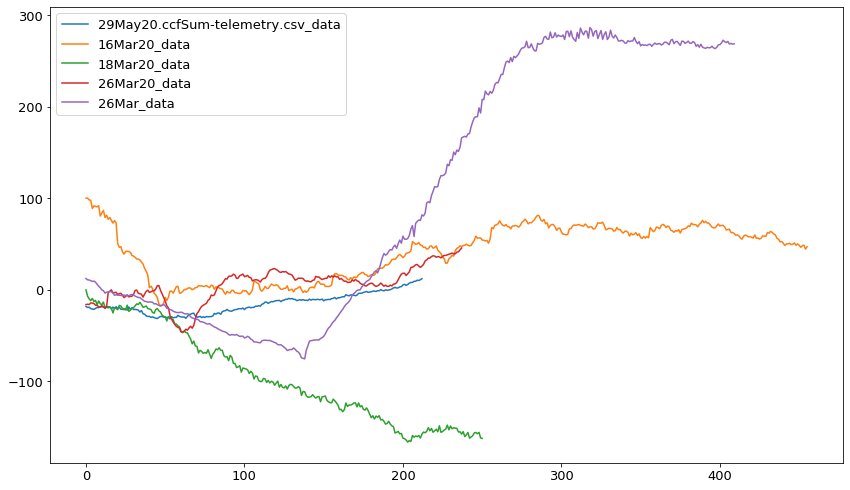

In [3]:
lengths = [len(data_dict[keys[i]]) for i in range(len(keys))]

plt.figure(figsize=(12,7))
for key in keys:
    plot_data = data_dict[key][:,1]
    plot_data = plot_data[np.isnan(plot_data) != True]
    plt.plot(plot_data, label=key)
plt.legend()
plt.tight_layout()
plt.show()

# sklearn time
## XGBoost

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[:,3:], data[:,1], test_size=0.25)

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

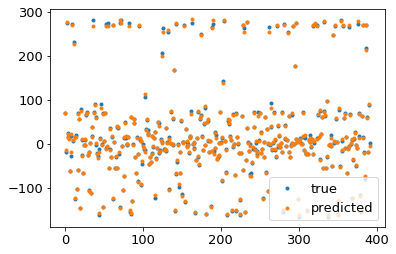

RMS = 2.932


In [5]:
plt.figure()
plt.plot(y_test, '.',label="true")
plt.plot(y_pred, '.', label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### New Split Shit

In [6]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

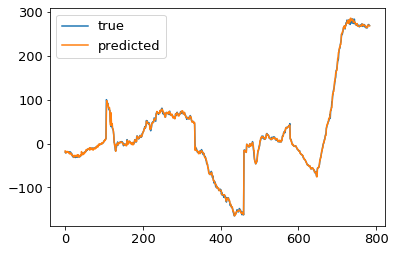

RMS = 3.150


In [7]:
plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Predict 1 timeseries

In [13]:
def test_1_timeseries(test_nr):
    # Choose which timeseries to test on with "timeseries_nr"
    # Make new test and train
    keyss = [keys[i] for i in range(4) if i!=test_nr]

    train = []
    for key in keyss:
        for vec in data_dict[key]:
            if not np.isnan(vec[0]):
                if (vec[3:] != 0).all():
                    train.append(vec)
    train = np.array(train)

    test = []
    for vec in data_dict[keys[test_nr]]:
        if not np.isnan(vec[0]):
            if (vec[3:] != 0).all():
                test.append(vec)
    test = np.array(test)
    return np.copy(train[:,3:]), np.copy(test[:,3:]), np.copy(train[:,1]), np.copy(test[:,1])

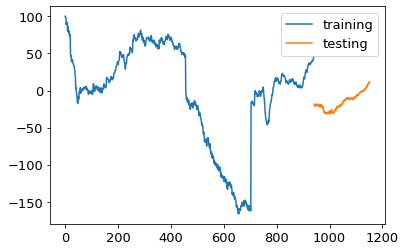

In [14]:
X_train, X_test, y_train, y_test = test_1_timeseries(0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

### XGboost

In [15]:
# Fit
mlp = xgb.XGBRegressor()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

In [24]:
# Create a model with no hyperparameters
clf_xgb = xgb.XGBRegressor(random_state=42, n_jobs=4)

# Parameters to search
parameters_RandomSearch = {
    "n_estimators": st.randint(1,10),
    "max_depth": st.randint(1,10),
    "learning_rate": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train)

# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.3s


Random Search: 	Best parameters:  {'learning_rate': 0.9977404850489419, 'max_depth': 1, 'n_estimators': 2} , Best scores: -48.1827


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


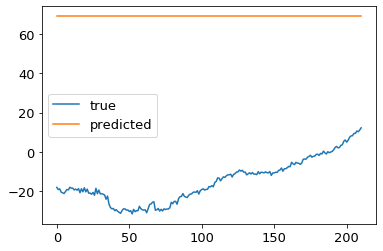

RMS = 84.941


In [25]:
y_pred = RandomSearch.predict(X_test)

plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Bayesian Optimization

In [30]:
from bayes_opt import BayesianOptimization
def xgboost_CrossValidation(num_round, eta, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=42, 
                                  num_round=num_round,
                                  eta=eta,
                                  max_depth=max_depth)
    
    cval = cross_val_score(estimator, data, targets, cv=5)
    
    return cval.mean()

def optimize_xgboost(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(num_round, eta, max_depth, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return xgboost_CrossValidation(max_depth=int(max_depth), 
                                       num_round=int(num_round),
                                       eta=eta,
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [31]:
parameters_BayesianOptimization = {"max_depth": (1, 10), 
                                   "num_round": (1, 15),
                                   "eta": (0,1)
                                  }

BayesianOptimization = optimize_xgboost(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=200)
print(BayesianOptimization.max)

|   iter    |  target   |    eta    | max_depth | num_round |
-------------------------------------------------------------
|  1        | -2.306    |  0.3745   |  9.556    |  11.25    |
|  2        | -1.272    |  0.5987   |  2.404    |  3.184    |
|  3        | -1.798    |  0.05808  |  8.796    |  9.416    |
|  4        | -0.6637   |  0.7081   |  1.185    |  14.58    |
|  5        | -0.9553   |  0.07992  |  1.005    |  9.516    |
|  6        | -4.657    |  0.0      |  10.0     |  1.0      |
|  7        | -2.773    |  1.0      |  3.743    |  12.2     |
|  8        | -3.254    |  0.943    |  4.311    |  4.098    |
|  9        | -4.157    |  0.8941   |  8.754    |  6.785    |
|  10       | -3.005    |  0.3323   |  7.119    |  14.48    |
|  11       | -1.78     |  0.09443  |  8.211    |  9.34     |
|  12       | -3.331    |  0.01205  |  1.0      |  13.87    |
|  13       | -0.642    |  0.7564   |  1.068    |  14.64    |
|  14       | -0.7032   |  0.689    |  1.612    |  14.98    |
|  15   

|  80       | -0.6276   |  0.5328   |  1.865    |  1.49     |
|  81       | -1.926    |  0.03657  |  1.693    |  1.161    |
|  82       | -0.3364   |  0.2722   |  1.59     |  1.705    |
|  83       | -2.326    |  0.9337   |  2.114    |  14.73    |
|  84       | -0.67     |  0.5068   |  1.342    |  1.61     |
|  85       | -3.791    |  0.8825   |  5.607    |  1.687    |
|  86       | -4.546    |  0.8782   |  6.189    |  5.186    |
|  87       | -2.08     |  0.7289   |  2.995    |  5.183    |
|  88       | -1.985    |  0.568    |  4.334    |  9.479    |
|  89       | -2.661    |  0.1209   |  9.491    |  13.96    |
|  90       | -0.9243   |  0.3342   |  2.007    |  1.834    |
|  91       | -0.7943   |  0.6407   |  1.659    |  1.835    |
|  92       | -0.6671   |  0.748    |  1.625    |  1.073    |
|  93       | -0.6054   |  0.505    |  1.071    |  12.58    |
|  94       | -0.6683   |  0.6876   |  1.941    |  1.12     |
|  95       | -0.9947   |  0.8452   |  1.536    |  1.443    |
|  96   

|  161      | -0.3245   |  0.2449   |  1.092    |  3.909    |
|  162      | -0.4128   |  0.1907   |  1.409    |  3.626    |
|  163      | -1.284    |  0.05811  |  1.489    |  4.081    |
|  164      | -0.6413   |  0.5324   |  1.434    |  3.726    |
|  165      | -2.927    |  0.8561   |  4.669    |  7.02     |
|  166      | -4.657    |  0.0      |  1.0      |  3.63     |
|  167      | -0.6783   |  0.4525   |  1.129    |  4.13     |
|  168      | -2.917    |  0.6375   |  5.269    |  12.47    |
|  169      | -0.7502   |  0.4194   |  1.821    |  3.329    |
|  170      | -0.3058   |  0.2944   |  1.694    |  3.653    |
|  171      | -0.644    |  0.3678   |  1.388    |  3.206    |
|  172      | -0.7125   |  0.5038   |  1.929    |  12.06    |
|  173      | -1.591    |  0.6766   |  2.355    |  11.8     |
|  174      | -1.717    |  0.04627  |  1.78     |  3.465    |
|  175      | -0.4291   |  0.3556   |  1.378    |  3.915    |
|  176      | -0.8845   |  1.0      |  1.0      |  12.11    |
|  177  

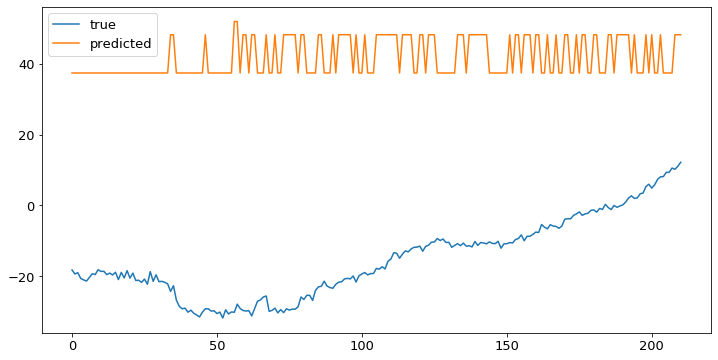

RMS = 58.048


In [32]:
model = xgb.XGBRegressor(eta = BayesianOptimization.max["params"]["eta"],
                          max_depth =int(BayesianOptimization.max["params"]["max_depth"]),
                          num_round = int(BayesianOptimization.max["params"]["num_round"]), 
                          random_state=42)

model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)#+155

# evaluate predictions
plt.figure(figsize=(12,6))
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

## NN

In [33]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [34]:
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

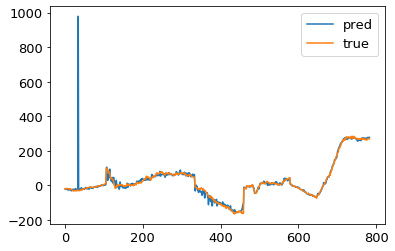

In [35]:
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV random search

In [36]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=5),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=0,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.9s finished


In [37]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (29, 21), 'learning_rate_init': 0.8209932298479351} , Best scores: -77.4209


115.37753683475707


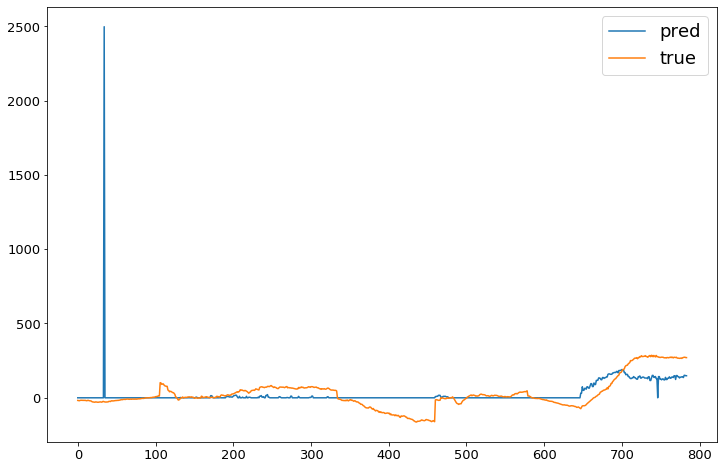

In [41]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
print(rms)
plt.figure(figsize=(12,8))
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend(fontsize=(18))
plt.show()

### Predict one timeseries

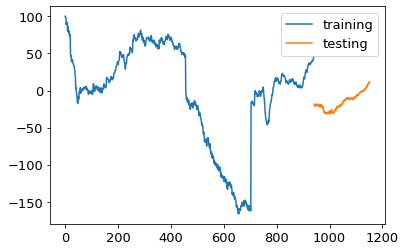

In [43]:
X_train, X_test, y_train, y_test = test_1_timeseries(0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

In [44]:
# Scale the data
# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [45]:
# Fit
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

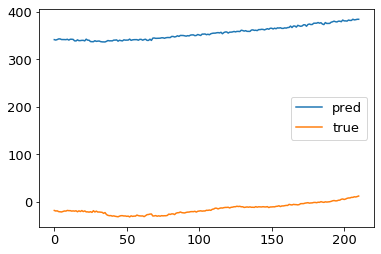

In [46]:
# Plotting
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV

In [60]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=10),
    "learning_rate_init": st.uniform(),
    "max_iter": st.randint(100,1000)
}

# Number of search rounds
n_iter_search = 50

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1)

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   26.4s finished


In [61]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (90, 29), 'learning_rate_init': 0.5986584841970366, 'max_iter': 714} , Best scores: -2.2339


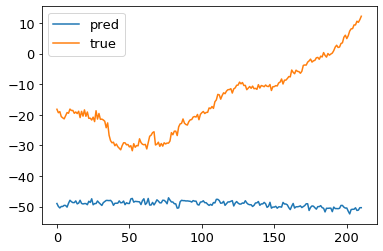

In [62]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()